In [1]:
import os
import pygame
DISPLAY = True
if not DISPLAY:
    os.environ["SDL_VIDEODRIVER"] = "dummy"

pygame 2.3.0 (SDL 2.24.2, Python 3.11.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Double Dueling Deep Q Network Learning with Priortized Experienced Reply

In [2]:
import os,sys
sys.path.append('game/')
import flappy_wrapped as game
import cv2
import numpy as np
import time
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
KERNEL = np.array([[-1,-1,-1], [-1, 9,-1],[-1,-1,-1]])
def processFrame(frame):
    frame = frame[55:288,0:400] #crop image
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY) #convert image to black and white
    frame = cv2.resize(frame,(84,84),interpolation=cv2.INTER_AREA)
    _ , frame = cv2.threshold(frame,50,255,cv2.THRESH_BINARY)
    #frame = cv2.blur(frame,(5,5))
    frame = cv2.filter2D(frame,-1,KERNEL)
    #frame = cv2.Canny(frame,100,200)
    frame = frame.astype(np.float64)/255.0
    return frame

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

#Dueling DQN
class DDQN(nn.Module):
    def __init__(self,input_shape,nactions):
        super(DDQN,self).__init__()
        self.nactions = nactions
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0],32,kernel_size=4,stride=2),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=2),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=2,stride=1),
            nn.ReLU()
        )
        
        conv_out_size = self._get_conv_out(input_shape)
        
        self.fca = nn.Sequential(
            nn.Linear( conv_out_size, 512),
            nn.ReLU(),
            nn.Linear( 512, nactions )
        )
        
        self.fcv = nn.Sequential(
            nn.Linear(conv_out_size,512),
            nn.ReLU(),
            nn.Linear(512,1)
        )
        
    def _get_conv_out(self,shape):
        o = self.conv( torch.zeros(1,*shape) )
        return int(np.prod(o.size()))
    
    def forward(self,x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        action_v = self.fca(conv_out)
        value_v = self.fcv(conv_out).expand(x.size(0), self.nactions)
        return value_v + action_v - action_v.mean(1).unsqueeze(1).expand(x.size(0), self.nactions)

In [5]:
ACTIONS = [0,1]
EXPERIENCE_BUFFER_SIZE = 2000
STATE_DIM = 4
GAMMA = 0.99
EPSILON_START = 1
EPSILON_FINAL = 0.001
EPSILON_DECAY_FRAMES = (10**4)/3
MEAN_GOAL_REWARD = 10
BATCH_SIZE = 32
MIN_EXP_BUFFER_SIZE = 500
SYNC_TARGET_FRAMES = 30
LEARNING_RATE = 1e-4
SKIP_FRAME = 2
INITIAL_SKIP = [0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1]

In [6]:
import collections
class ExperienceBuffer():
    def __init__(self,capacity):
        self.buffer = collections.deque(maxlen=capacity)
        self.priority = collections.deque(maxlen=capacity)
    
    def clear(self):
        self.buffer.clear()
        self.priority.clear()
        
    def __len__(self):
        return len(self.buffer)
    
    def append(self,exp,p):
        self.buffer.append(exp)
        self.priority.append(p)
        
    def sample(self,batch_size):
        probs = np.array(self.priority)/sum(np.array(self.priority))
        indices = np.random.choice( range(len(self.buffer)), batch_size, p = probs)
        states,actions,rewards,dones,next_states = zip(*[ self.buffer[idx] for idx in indices ])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32),\
    np.array(dones,dtype=np.uint8), np.array(next_states)

In [7]:
class Agent():
    def __init__(self,env,buffer,state_buffer_size = STATE_DIM):
        self.env = env
        self.exp_buffer = buffer
        self.state = collections.deque(maxlen = STATE_DIM)
        self.next_state= collections.deque(maxlen = STATE_DIM)
        self._reset()
        
    def _reset(self):
        self.total_rewards = 0
        self.state.clear()
        self.next_state.clear()
        
        for i in INITIAL_SKIP[:-7]:
            frame,reward,done = self.env.frame_step(i)
            self.total_rewards+=reward
            if done:
                self._reset()
        frame = processFrame(frame)
        self.state.append(frame)
        self.next_state.append(frame)

        for i in INITIAL_SKIP[-7:-5]:
            frame,reward,done = self.env.frame_step(i)
            self.total_rewards+=reward
            if done:
                self._reset()
        frame = processFrame(frame)
        self.state.append(frame)
        self.next_state.append(frame)
        
        for i in INITIAL_SKIP[-5:-3]:
            frame,reward,done = self.env.frame_step(i)
            self.total_rewards+=reward
            if done:
                self._reset()
        frame = processFrame(frame)
        self.state.append(frame)
        self.next_state.append(frame)
        
        for i in INITIAL_SKIP[-3:-1]:
            frame,reward,done = self.env.frame_step(i)
            self.total_rewards+=reward
            if done:
                self._reset()
        frame = processFrame(frame)
        self.state.append(frame)
        self.next_state.append(frame)
    
    def step(self,net,tgt_net,epsilon=0.9,device='cpu'):
        self.total_rewards = 0
        if np.random.random() < epsilon:
            action = np.random.choice(ACTIONS)
        else:
            state_v = torch.tensor(np.array([self.state],copy=False),dtype=torch.float32).to(device)
            action = int(torch.argmax(net(state_v)))
       
        frame,reward,done = self.env.frame_step(action)
        self.total_rewards += reward
        for _ in range(SKIP_FRAME):
                frame,reward,done =  self.env.frame_step(action)
                self.total_rewards += reward
                if done:
                    break
                    
        frame = processFrame(frame)
        self.next_state.append(frame)
        
        if len(self.next_state)==STATE_DIM and len(self.state)==STATE_DIM:
            #PER - Prioritized Experience Replay
            o = net( torch.tensor( np.array([self.state]),dtype=torch.float32).to(device)).to('cpu').detach().numpy()[0][action]
            e = float(torch.max(tgt_net( torch.tensor( np.array([self.next_state]),dtype=torch.float32).to(device))))
            p = abs(o-e)+0.0001
            self.exp_buffer.append((self.state.copy(),action,int(self.total_rewards),done,self.next_state.copy()),p)
        
        self.state.append(frame)
        
        end_reward = int(self.total_rewards)
        if done:
            self._reset()
        
        return end_reward

In [8]:
def calc_loss(batch,net,tgt_net,device='cpu'):
    states,actions,rewards,dones,next_states = batch
    
    states_v = torch.tensor(states,dtype=torch.float32).to(device)
    actions_v = torch.tensor(actions,dtype=torch.long).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    dones_v = torch.ByteTensor(dones).to(device)
    next_states_v = torch.tensor(next_states,dtype=torch.float32).to(device)
    
    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    next_state_action_values = tgt_net(next_states_v).max(1)[0]
    next_state_action_values[dones_v] = 0.0
    next_state_action_values = next_state_action_values.detach() 
    
    expected_values = rewards_v +  next_state_action_values * GAMMA
    return nn.MSELoss()(state_action_values,expected_values)

In [9]:
all_losses = []
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )

#Double Dueling DQN
net = DDQN( (STATE_DIM,84,84), len(ACTIONS) ).to(device)
tgt_net = DDQN( (STATE_DIM,84,84), len(ACTIONS) ).to(device)

env = game.GameState()
buffer = ExperienceBuffer(EXPERIENCE_BUFFER_SIZE)
agent = Agent(env,buffer)
epsilon = EPSILON_START
optimizer = optim.Adam(net.parameters(),lr=LEARNING_RATE)

total_rewards = []
best_mean_reward = float('-inf')
last_mean = float('-inf')
game_id = 0
while True:
    epsilon = max( EPSILON_FINAL , EPSILON_START - game_id/EPSILON_DECAY_FRAMES )

    reward = agent.step(net,tgt_net,epsilon,device=device)
    if reward != 0:
        game_id += 1
        total_rewards.append(reward)
        mean_reward = np.mean(total_rewards[-100:])
        if game_id%5 == 0:
            print("GAME : {} | EPSILON : {:.4f} | MEAN REWARD : {}".format( game_id, epsilon, mean_reward ))
        if best_mean_reward < mean_reward:
            best_mean_reward = mean_reward

            if best_mean_reward - last_mean >= 0.1:
                torch.save(net.state_dict(),'checkpoints/flappy_best_model.dat')
                print(f"REWARD {last_mean} -> {mean_reward}. Model Saved")
                last_mean = best_mean_reward

        if game_id % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())

        if mean_reward >= MEAN_GOAL_REWARD:
            print(f"Learned in {game_id} Games.")
            break

    if len(buffer) < MIN_EXP_BUFFER_SIZE:
        continue

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch,net,tgt_net,device=device)
    all_losses.append(float(loss_t))
    loss_t.backward()
    optimizer.step()

REWARD -inf -> -1.0. Model Saved
GAME : 5 | EPSILON : 0.9988 | MEAN REWARD : -1.0
GAME : 10 | EPSILON : 0.9973 | MEAN REWARD : -1.0
GAME : 15 | EPSILON : 0.9958 | MEAN REWARD : -1.0
GAME : 20 | EPSILON : 0.9943 | MEAN REWARD : -1.0
GAME : 25 | EPSILON : 0.9928 | MEAN REWARD : -1.0
GAME : 30 | EPSILON : 0.9913 | MEAN REWARD : -1.0
GAME : 35 | EPSILON : 0.9898 | MEAN REWARD : -1.0
GAME : 40 | EPSILON : 0.9883 | MEAN REWARD : -1.0
GAME : 45 | EPSILON : 0.9868 | MEAN REWARD : -0.9555555555555556
GAME : 50 | EPSILON : 0.9853 | MEAN REWARD : -0.96
GAME : 55 | EPSILON : 0.9838 | MEAN REWARD : -0.9636363636363636
GAME : 60 | EPSILON : 0.9823 | MEAN REWARD : -0.9666666666666667


/var/folders/bx/xky7r7wj4jv7pmpyhfjcvh340000gn/T/ipykernel_48633/2056532060.py:12: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1773.)
  next_state_action_values[dones_v] = 0.0


GAME : 65 | EPSILON : 0.9808 | MEAN REWARD : -0.9692307692307692
GAME : 70 | EPSILON : 0.9793 | MEAN REWARD : -0.9714285714285714
GAME : 75 | EPSILON : 0.9778 | MEAN REWARD : -0.9733333333333334
GAME : 80 | EPSILON : 0.9763 | MEAN REWARD : -0.95
GAME : 85 | EPSILON : 0.9748 | MEAN REWARD : -0.9529411764705882
GAME : 90 | EPSILON : 0.9733 | MEAN REWARD : -0.9555555555555556
GAME : 95 | EPSILON : 0.9718 | MEAN REWARD : -0.9578947368421052
GAME : 100 | EPSILON : 0.9703 | MEAN REWARD : -0.96
GAME : 105 | EPSILON : 0.9688 | MEAN REWARD : -0.96
GAME : 110 | EPSILON : 0.9673 | MEAN REWARD : -0.96
GAME : 115 | EPSILON : 0.9658 | MEAN REWARD : -0.96
GAME : 120 | EPSILON : 0.9643 | MEAN REWARD : -0.96
GAME : 125 | EPSILON : 0.9628 | MEAN REWARD : -0.94
GAME : 130 | EPSILON : 0.9613 | MEAN REWARD : -0.94
GAME : 135 | EPSILON : 0.9598 | MEAN REWARD : -0.94
GAME : 140 | EPSILON : 0.9583 | MEAN REWARD : -0.94
GAME : 145 | EPSILON : 0.9568 | MEAN REWARD : -0.94
GAME : 150 | EPSILON : 0.9553 | MEAN RE

KeyboardInterrupt: 

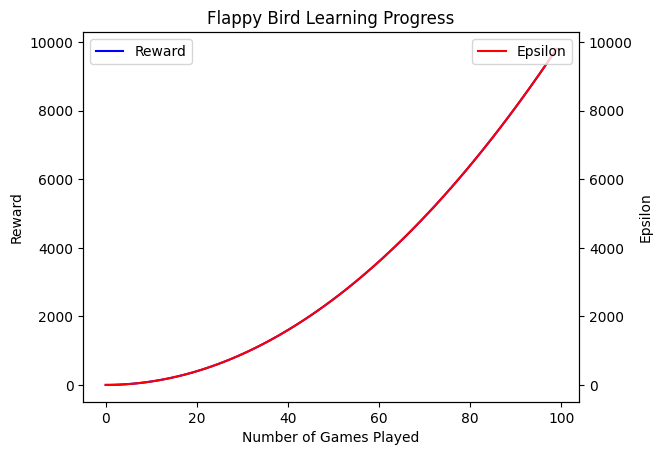

In [11]:
import matplotlib.pyplot as plt

# Example data
num_games = list(range(100))
epsilon = [1/(i+1) for i in range(100)]
score = [i**2 for i in range(100)]

# Create figure and axes
fig, ax1 = plt.subplots()

# Plot the number of games played
ax1.plot(num_games, score, 'b-', label='Reward')
ax1.set_xlabel('Number of Games Played')
ax1.set_ylabel('Reward')

# Create a second y-axis for epsilon
ax2 = ax1.twinx()
ax2.plot(num_games, score, 'r-', label='Epsilon')
ax2.set_ylabel('Epsilon')

# Add legend and title
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Flappy Bird Learning Progress')

# Show plot
plt.show()


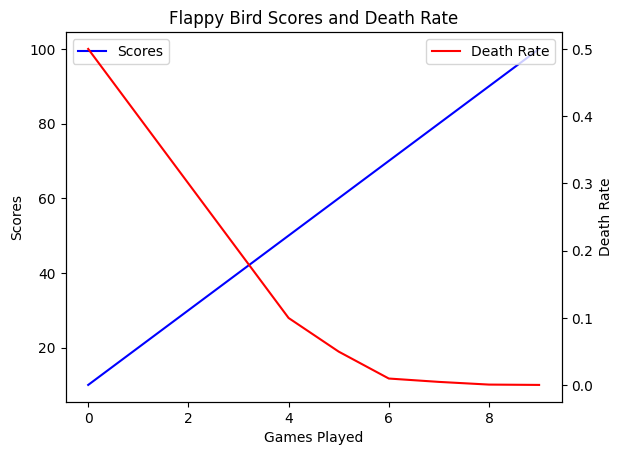